# Telecomm - Exploratory Analysis

# Context:

A telecommunications company gave me access to data of a user. They don't think that all that data is useful in any sense, so my job is to prove them wrong and show that we can learn a lot from a user's cell phone data.

# The Data

The [person's metadata](./datasets/metadata.csv) has the following fields:

| Field Name          | Description
| ---                 | ---
| **Cell Cgi**        | cell phone tower identifier
| **Cell Tower**      | cell phone tower location
| **Comm Identifier** |	de-identified recipient of communication
| **Comm Timedate String** | time of communication
| **Comm Type	Id**  | type of communication
| **Latitude**        | latitude of communication
| **Longitude**       | longitude of communication

In [1]:
#First we need to import all libraries.
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import datetime as dt

%matplotlib inline

In [2]:
#Import file
file_location = 'datasets/metadata.csv'
df = pd.read_csv(file_location)

In [3]:
#Data Exploration/Understanding:
df.describe() #Some stats
df.info() #No null cells
df.dtypes #Just strings and numbers, no special datatypes
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10476 entries, 0 to 10475
Data columns (total 7 columns):
Cell Cgi                10476 non-null object
Cell Tower Location     10476 non-null object
Comm Identifier         1374 non-null object
Comm Timedate String    10476 non-null object
Comm Type               10476 non-null object
Latitude                10476 non-null float64
Longitude               10476 non-null float64
dtypes: float64(2), object(5)
memory usage: 573.0+ KB


,Cell Cgi,Cell Tower Location,Comm Identifier,Comm Timedate String,Comm Type,Latitude,Longitude
0,50501015388B9,REDFERN TE,f1a6836c0b7a3415a19a90fdd6f0ae18484d6d1e,4/1/14 9:40,Phone,-33.892933,151.202296
1,50501015388B9,REDFERN TE,62157ccf2910019ffd915b11fa037243b75c1624,4/1/14 9:42,Phone,-33.892933,151.202296
2,505010153111F,HAYMARKET #,c8f92bd0f4e6fb45ed7fce96fc831b283db2b642,4/1/14 13:13,Phone,-33.880329,151.205690
3,505010153111F,HAYMARKET #,f1a6836c0b7a3415a19a90fdd6f0ae18484d6d1e,4/1/14 13:13,Phone,-33.880329,151.205690
4,5.05E+106,HAYMARKET #,f1a6836c0b7a3415a19a90fdd6f0ae18484d6d1e,4/1/14 17:27,Phone,-33.880329,151.205690


# I'm curious to plot these geolocations in a map by communication type.

In [4]:
#Create a column with the coordinates by pairing up Longitude and Latitude.
#Then I'm going to use Geopandas to plot the data in a map.
geometry = [Point(xy) for xy in zip(df['Longitude'],df['Latitude'])] #Creating my coordinates
geo_df = gpd.GeoDataFrame(df, geometry = geometry) #Creating a new dataframe to plot on

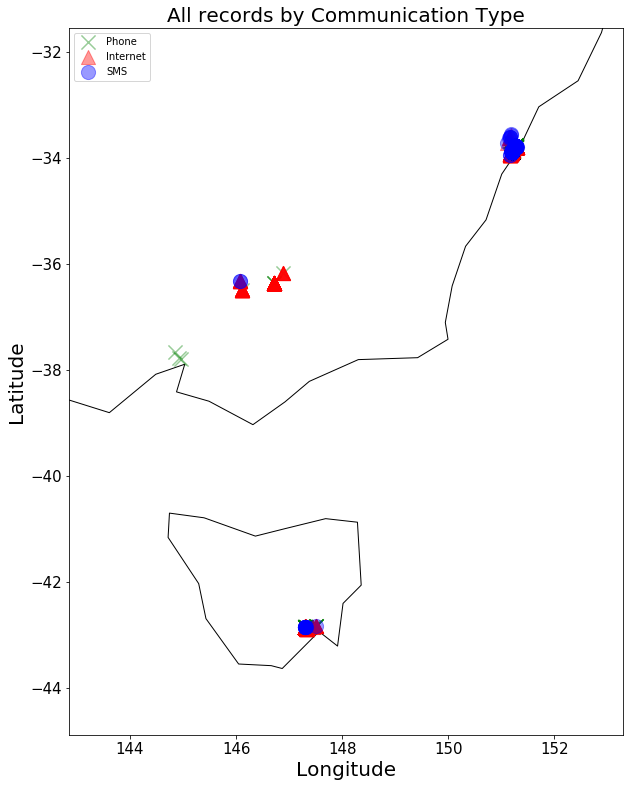

In [5]:
#Okay, we're ready to plot!
#Downloading map information from database.
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#Restrict to Oceania.
ax = world[world.continent == 'Oceania'].plot(color='white', edgecolor='black', figsize = (13,13))

#Define max and min of my axis.
minx, miny, maxx, maxy = geo_df.total_bounds
ax.set_xlim(minx - 2, maxx + 2)
ax.set_ylim(miny - 2, maxy + 2)

#Create all dataframes to plot, also pick different colors and markers and put labels.
geo_df[geo_df['Comm Type'] == 'Phone'].plot(ax=ax, color='green', label = 'Phone', marker = 'x', alpha = .4, markersize = 200)
geo_df[geo_df['Comm Type'] == 'Internet'].plot(ax=ax, color='red', label = 'Internet', marker = '^', alpha = .4, markersize = 200)
geo_df[geo_df['Comm Type'] == 'SMS'].plot(ax=ax, color='blue', label = 'SMS', marker = 'o', alpha = .4, markersize = 200)

#Title and labels
plt.title('All records by Communication Type', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Longitude', fontsize = 20)
plt.ylabel('Latitude', fontsize = 20)
plt.legend(loc='upper left')
plt.show()

### It's interesting to see that the user doesn't communicate through SMS in all places (note (146,37) and (145, 38)). Besides, in (145, 38), the person only uses the phone, no SMS or Internet. 
### Another observation to be made is that the locations are too well defined, I can clearly see 4 different locations. I'd expect to see more data between those 4 points, however, it's possible that while the user is driving, he/she doesn't use the phone at all, which is odd, but that's what the data is suggesting.

### Well, moving on, I wonder how many records we have for each Communication Type.

In [6]:
df.groupby(['Comm Type']).count()['Latitude']

Comm Type
Internet    9102
Phone        717
SMS          657
Name: Latitude, dtype: int64

### This analysis indicates that the user communicates more through the Internet, however, it's possible that every ping counts as one record, which could be misleading for this type of simple analysis. I'll make sure to keep that in mind for future analysis, but for now let's move on ...

## I wonder if we could find any trends or patterns using dates and location. The idea is to see this person's day to day, try to identify where he/she works and lives.

In [7]:
#Basic updates:
#Converting the Comm Timedate String column into a datetime and assigning it to a different column.
#Then, I'm going to sort by date and reset my index, because I want my index to have a chronological order.
df['communication_time'] = pd.to_datetime(df['Comm Timedate String'])
df = df.sort_values(by='communication_time').reset_index()

#I'm going to strip the date into different columns, creating columns for Year, Month, Weekday, Hour and Day.
df['communication_year'] = df['communication_time'].map(lambda x: x.year)
df['communication_month'] = df['communication_time'].map(lambda x: x.month)
df['communication_weekday'] = df['communication_time'].map(lambda x: x.weekday())
df['communication_hour'] = df['communication_time'].map(lambda x: x.time())
df['communication_day'] = df['communication_time'].map(lambda x: x.day)
df['just_date'] = df['communication_time'].dt.date

## Now, my idea is to group similar locations, so I have less groups to analyze. Based on the map above, as I said before, I see 4 clear different locations. I'm going to label them 1, 2, 3 and 4.

In [8]:
#In order to do that, first of all, I'm going to concatenate the Latitude and Longitude columns and convert them 
#to strings, this will help be to efficiently categorize them.
df['geometry_string'] = df['Latitude'].map(lambda x: str(round(x))) + ', ' + df['Longitude'].map(lambda x: str(round(x)))
df['geometry_string'].unique() # to get the unique combinations and create the conditions below.

#Create a new column for the category and set the value to zero. Then, update the column based on the coordinates.
df['geometry_category'] = 0
df['geometry_category'].loc[(df['geometry_string'] == '-36, 146') | (df['geometry_string'] == '-36, 147')] = 1
df['geometry_category'].loc[(df['geometry_string'] == '-37, 146') | (df['geometry_string'] == '-38, 145')] = 2
df['geometry_category'].loc[(df['geometry_string'] == '-43, 148') | (df['geometry_string'] == '-43, 147')] = 3
df['geometry_category'].loc[(df['geometry_string'] == '-34, 151')] = 4
df['geometry_category'].unique() #Make sure that we don't have zeros
#Based on the result below it looks my category column is good to go.

/Users/reno/anaconda2/envs/py365/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


array([4, 3, 2, 1])

### Okay, now that I have all I need, I'm going to plot the location overtime. Hopefully we'll see patterns.

In [9]:
#I'm going to create a new dataframe and group the date and category columns (so I can keep unique pairs of location 
#and date), then I'm going to use a count just to create my dataframe, after that the count column will be deleted.
df_justdate = pd.DataFrame(df.groupby(['just_date','geometry_category']).count()['communication_year'].reset_index())
df_justdate.drop('communication_year',1, inplace = True)
df_justdate.set_index(['just_date'],inplace=True) #set the index to the just_date column, so we can plot that.

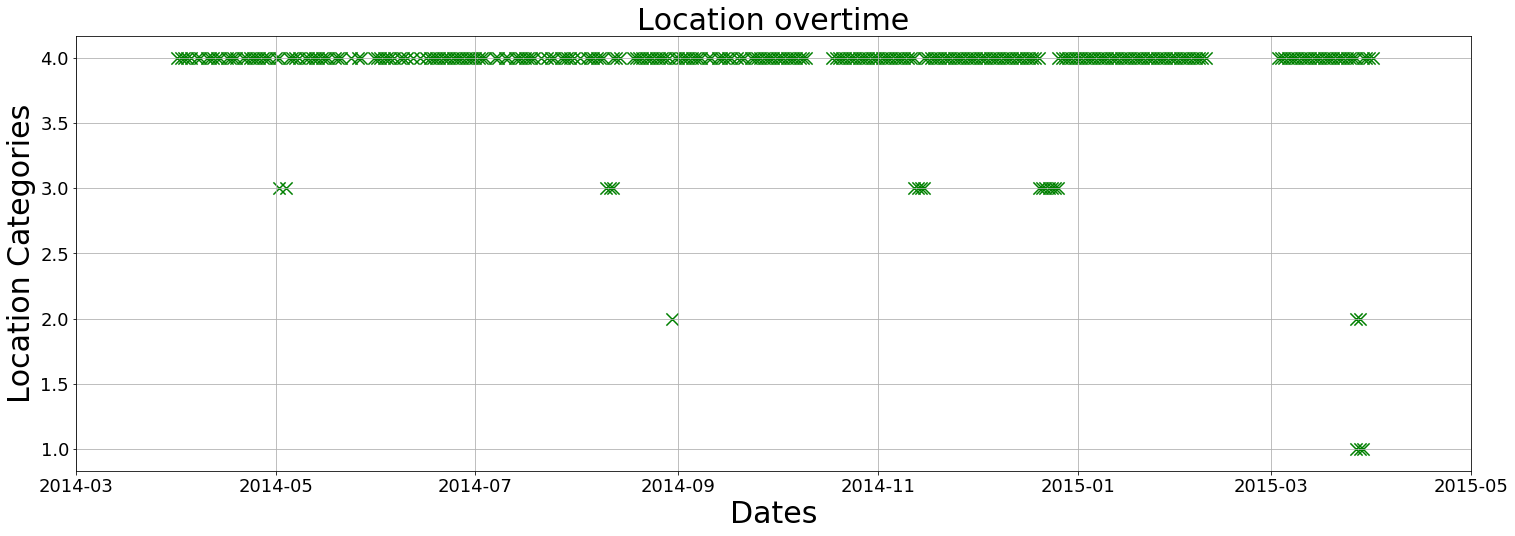

In [10]:
#It's time to plot 
plt.figure(figsize=(25,8))
plt.title('Location overtime', fontsize = 30)
plt.xlabel('Dates', fontsize = 30)
plt.ylabel('Location Categories', fontsize = 30)
plt.grid()
plt.xlim([dt.date(2014, 3, 1), dt.date(2015, 5, 1)])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.scatter(df_justdate.index, df_justdate['geometry_category'], s = 150, c = 'green', marker = 'x');

#### Based on the chart above, it's possible to conclude the following:
- The user spends most of the time in location 4 (151,-34). 
- Between 2015-mid-Feb and beginning of March and for a few days in October-2014, we have no data. A possibility would be that the person was on vacation or the telephone was in repair.
- It's possible to say that the user regularly goes to location 3. The difference between the first-second and second-third points is the same (3 months) and around the end of the year (including Christmas 12/20 to 12/26) we have some records too. My theory would be that it's a family location, like the user's parents house or something like that. I even checked for holidays in Sydney in May, August and November prove my theory, but couldn't find anything ...

In [11]:
#I'm curious to see the count of each category.
df_justdate['count'] = 1
df_justdate.groupby('geometry_category').count()['count']

geometry_category
1      3
2      3
3     16
4    292
Name: count, dtype: int64

#### Same conclusions stated by the chart above. The user spends most of the time in location 4.

## Next, I'm going to create the same chart by Communication Type, I wonder if certain type of communication is preferred depending on the location.

In [12]:
#First step is to create the dataframes.
#Phone:
#Filtering my dataframe to include only Phone.
df_justdate_phone = pd.DataFrame(df[df['Comm Type'] == 'Phone'].groupby(['just_date','geometry_category']).count()['communication_year'].reset_index())
df_justdate_phone.reset_index(inplace=True)
#Creating dataframe to plot.
df_chart_phone = pd.DataFrame(df_justdate_phone, columns = ['just_date','geometry_category'])
df_chart_phone.drop_duplicates('just_date') #dropping duplicates to make it look cleaner
df_chart_phone['geometry_category'] = df_chart_phone['geometry_category'] + 0.1 #adjustment to make plot look better, easier to differentiate.
df_chart_phone.set_index(['just_date'],inplace=True)

#SMS:
#Filtering my dataframe to include only SMS.
df_justdate_sms = pd.DataFrame(df[df['Comm Type'] == 'SMS'].groupby(['just_date','geometry_category']).count()['communication_year'].reset_index())
df_justdate_sms.reset_index(inplace=True)
#Creating a dataframe to plot
df_chart_sms = pd.DataFrame(df_justdate_sms, columns = ['just_date','geometry_category'])
df_chart_sms.drop_duplicates('just_date') #dropping duplicates to make it look cleaner
df_chart_sms.set_index(['just_date'],inplace=True)

#Internet:
#Filtering my dataframe to include only Internet.
df_justdate_internet = pd.DataFrame(df[df['Comm Type'] == 'Internet'].groupby(['just_date','geometry_category']).count()['communication_year'].reset_index())
df_justdate_internet.reset_index(inplace=True)
#Creating a dataframe to plot
df_chart_internet = pd.DataFrame(df_justdate_internet, columns = ['just_date','geometry_category'])
df_chart_internet.drop_duplicates('just_date') #dropping duplicates to make it look cleaner
df_chart_internet['geometry_category'] = df_chart_internet['geometry_category'] - 0.1 #adjustment to make plot look better, easier to differentiate.
df_chart_internet.set_index(['just_date'],inplace=True)

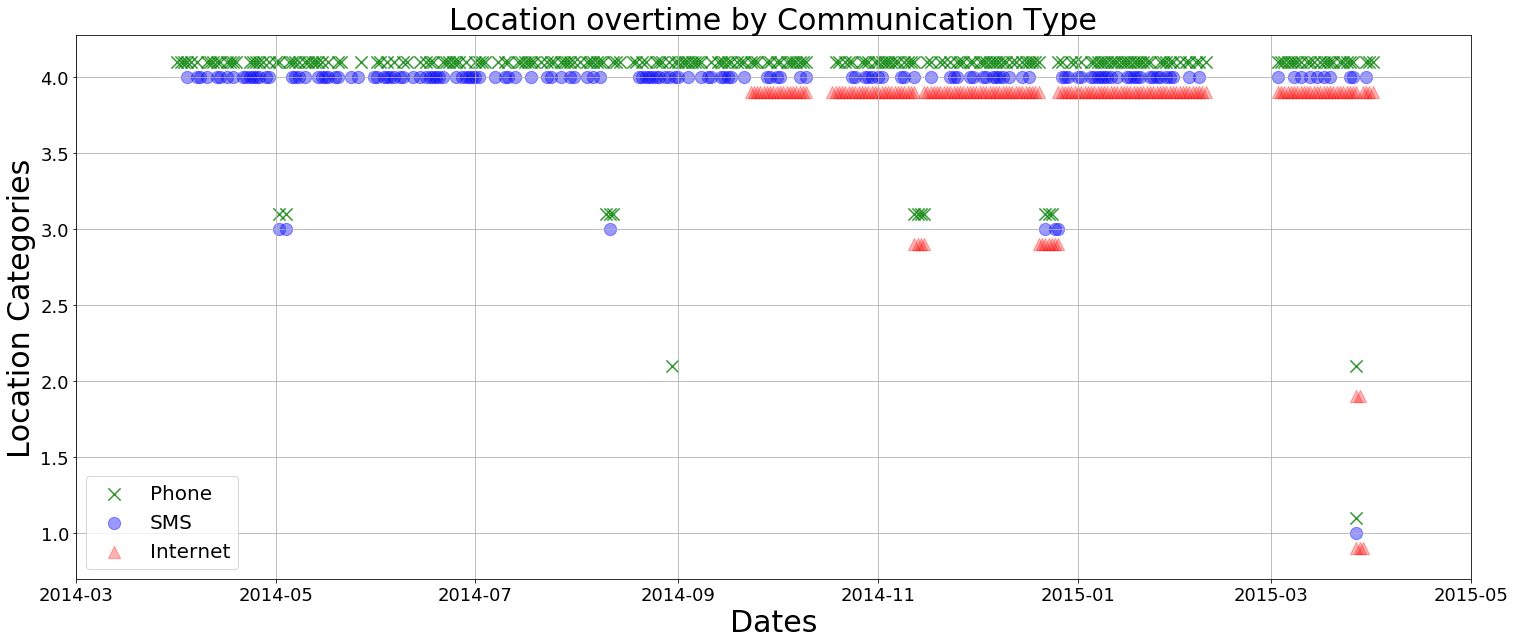

In [13]:
#Finally, it's time to plot all dataframes!
plt.figure(figsize=(25,10))
plt.title('Location overtime by Communication Type', fontsize = 30)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim([dt.date(2014, 3, 1), dt.date(2015, 5, 1)])
plt.grid()
plt.xlabel('Dates', fontsize = 30)
plt.ylabel('Location Categories', fontsize = 30)
plt.scatter(df_chart_phone.index, df_chart_phone['geometry_category'],color='green', label = 'Phone', marker = 'x', s = 150, alpha = .8)
plt.scatter(df_chart_sms.index, df_chart_sms['geometry_category'], color='blue', label = 'SMS', marker = 'o', s = 150, alpha = .4)
plt.scatter(df_chart_internet.index, df_chart_internet['geometry_category'], color='red', label = 'Internet', marker = '^', s = 150, alpha = .3)
plt.legend(prop={'size': 20});

## Conclusion: The user didn't have access to the Internet for basically half of the period that we are analyzing. At the end of 2014 though, Internet was added to the cellphone plan.

## Now I'm curious to see if the addition of Internet had an impact on Phone and SMS numbers. My hypothesis is that Internet will replace phonecalls and texting.

In [14]:
#In order to do that, I need the number of monthly records per Communication Type.
#So, below I'm grouping records by Communication Type, Month and Year and counting.
internet_impact_df = pd.DataFrame(df.groupby(['Comm Type','communication_month','communication_year']).count()['Latitude']).reset_index()

#Below, in order to plot the data by date I created a date column using the year and month and chose '1' to be the day.
#Therefore I'm plotting assuming that everything happened on the first day of the month.
internet_impact_df['date'] = pd.to_datetime(internet_impact_df['communication_year'].map(str) + '-' + internet_impact_df['communication_month'].map(str) + '-01')
internet_impact_df.drop(['communication_year','communication_month'],1, inplace = True)
internet_impact_df.columns = ['communication_type','count','date']
internet_impact_df.sort_values('date', inplace = True)
internet_impact_df.set_index(['date'],inplace = True)

#The final dataframe after removing columns, renaming others and resetting the index is the following:
internet_impact_df.head()

,communication_type,count
date,,
2014-04-01,Phone,60
2014-04-01,SMS,98
2014-05-01,SMS,73
2014-05-01,Phone,47
2014-06-01,Phone,29


In [15]:
#Now I need to create a df for each type of communication type in order to plot that.
internet_records = internet_impact_df[internet_impact_df['communication_type'] == 'Internet']
sms_records = internet_impact_df[internet_impact_df['communication_type'] == 'SMS']
phone_records = internet_impact_df[internet_impact_df['communication_type'] == 'Phone']

In [16]:
#Since we have more Internet records, if we plot all types on the same chart, Phone and SMS numbers will loook
#too small to be analyzed. Therefore, I'll use just the date of the first Internet record and put an observation 
#on the chart.
df[df['Comm Type'] == 'Internet']['just_date'][:1]

#First Internet Record was in 2014-09-23.

665    2014-09-23
Name: just_date, dtype: object

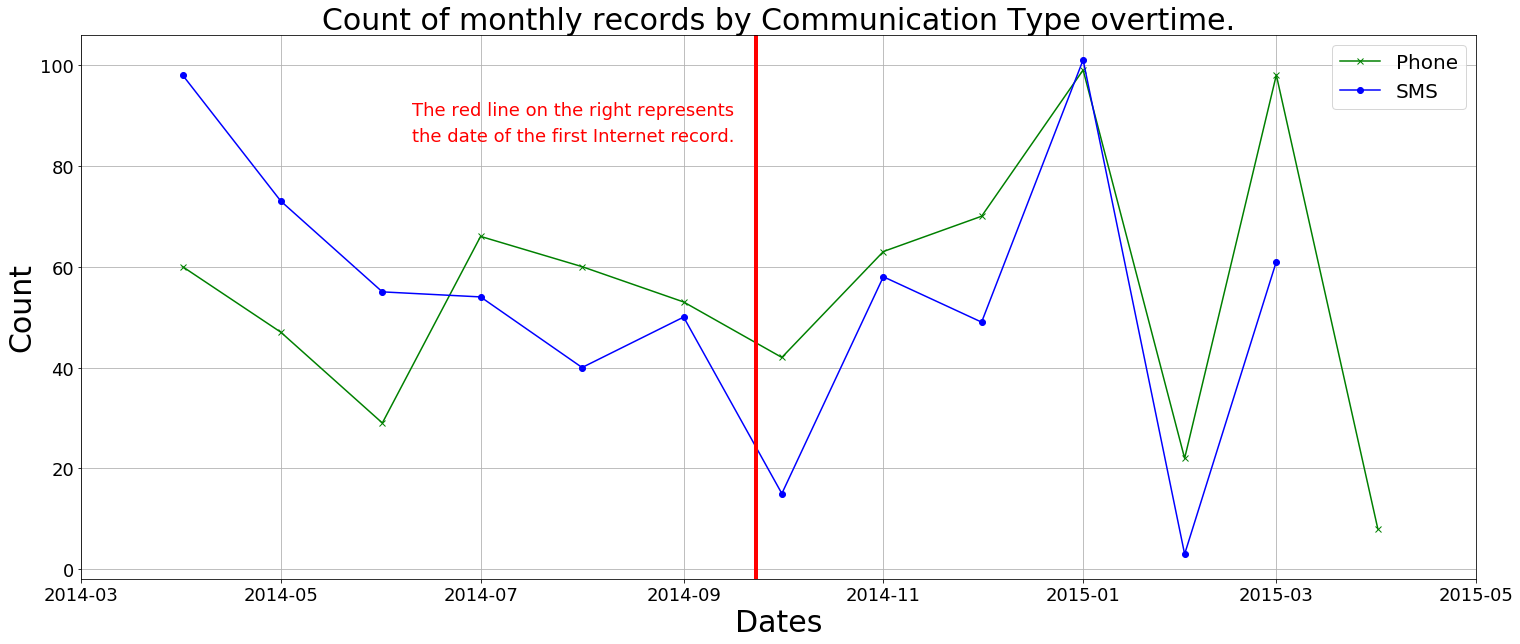

In [17]:
#Plotting
plt.figure(figsize=(25,10))
plt.title('Count of monthly records by Communication Type overtime.', fontsize = 30)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim([dt.date(2014, 3, 1), dt.date(2015, 5, 1)])
plt.grid()
plt.xlabel('Dates', fontsize = 30)
plt.ylabel('Count', fontsize = 30)
plt.plot(phone_records.index, phone_records['count'],color='green', label = 'Phone', marker = 'x')
plt.plot(sms_records.index, sms_records['count'], color='blue', label = 'SMS', marker = 'o')
plt.axvline(x='2014-09-23',linewidth=4, color = 'red')
plt.text('2014-06-10', 90, 'The red line on the right represents', fontsize=18, color = 'red')
plt.text('2014-06-10', 85, 'the date of the first Internet record.', fontsize=18, color = 'red')
plt.legend(prop={'size': 20});

### Well the conclusion is that my hypothesis was wrong, I don't see any changes, matter of fact, there was an increase on the monthly count of SMS and Phone records. Don't forget that 2015-Feb should be ignored, since it's that period in which we don't have data for the most part.

## Now it's time to use the Communication Identifier column, I want to know the top 5 contacts and in which time of the day the user communicates with them.

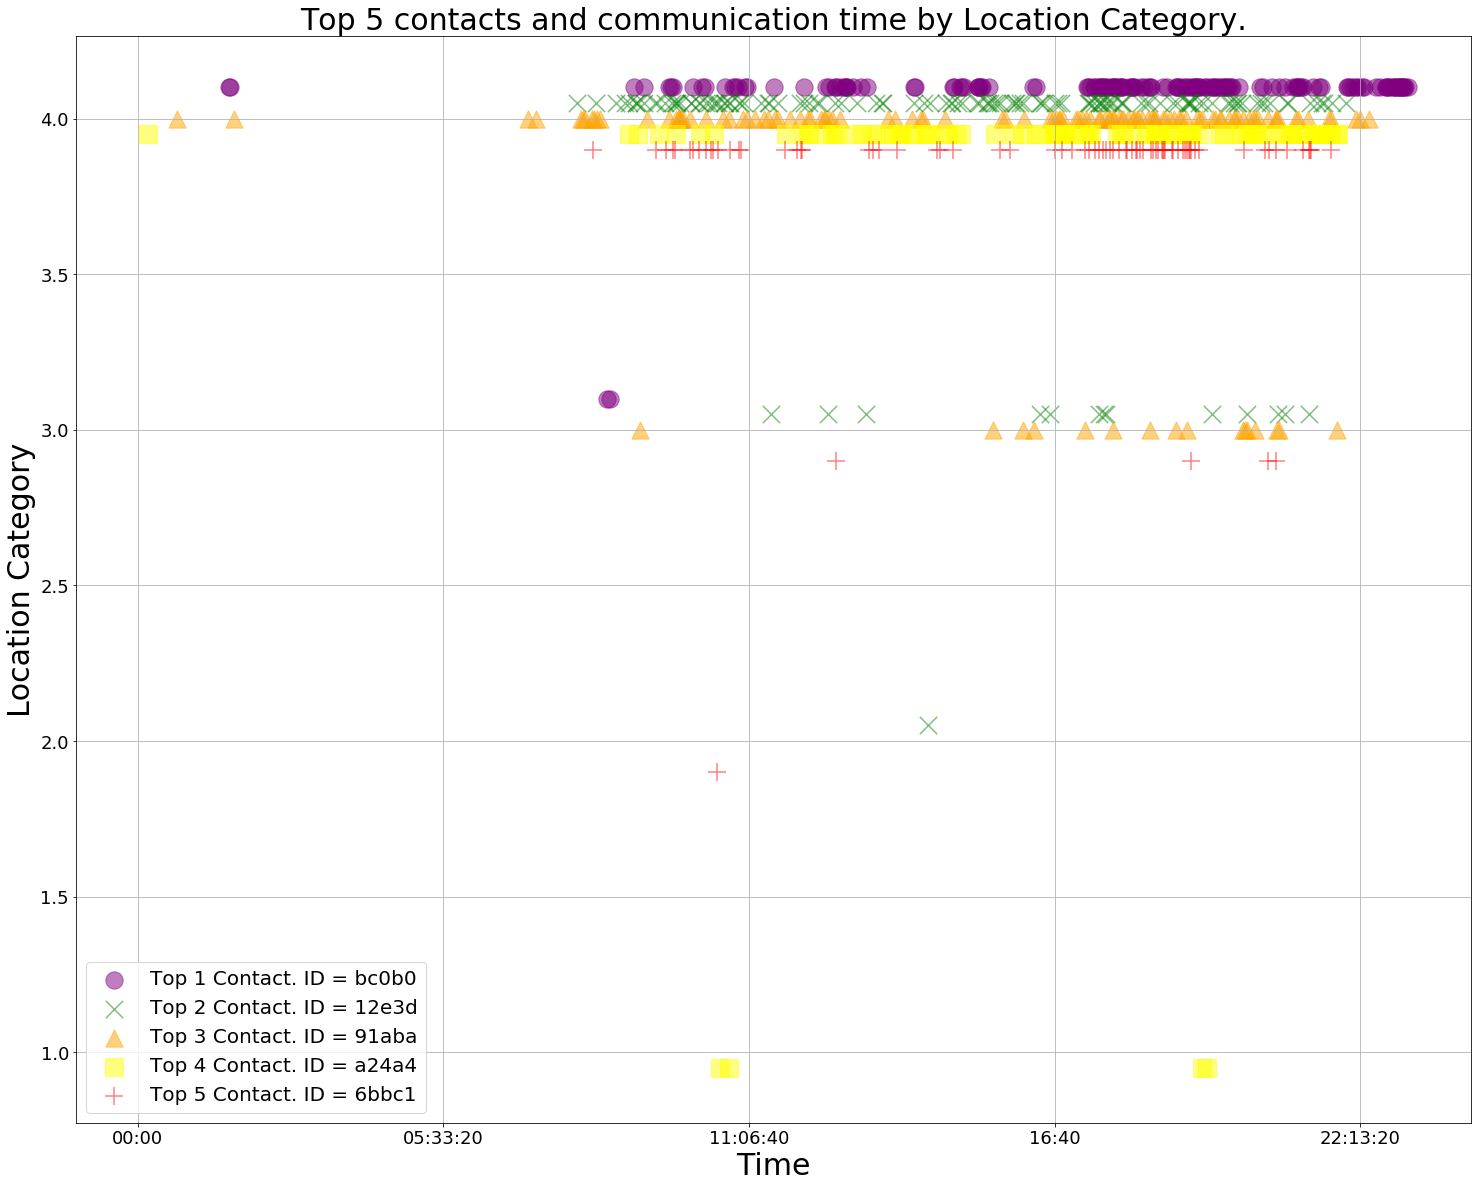

In [18]:
#Creating a list of the top 5 contacts.
top_ids = pd.DataFrame(df.groupby('Comm Identifier').count()['Latitude'].sort_values(ascending=False).head(5)).reset_index()
top_ids = list(top_ids['Comm Identifier'])

#Creating my plot.
plt.figure(figsize=(25,20))

#A loop to go through all records and plot them.
for idx, comm_id in enumerate(top_ids):
    color = ['purple','green','orange','yellow','red'] #list of colors for my chart
    chart_adj = [.1,.05,0,-.05,-.1]
    marker = ['o', 'x', '^', 's', '+'] #list of markers
    label = 'Top ' + str(idx + 1) + ' Contact. ID = ' + str(comm_id[:5]) #labels.
    #Dynamically creating each dataframe for each contact. The frame is just a count of hour and location by contact, then I'll drop the count later.
    top_df = pd.DataFrame(df[df['Comm Identifier'] == comm_id].groupby(['communication_hour','geometry_category']).count()['communication_year'].reset_index())
    top_df.reset_index(inplace=True)
    top_df_chart = pd.DataFrame(top_df, columns = ['communication_hour','geometry_category'])
    top_df_chart['geometry_category'] = top_df_chart['geometry_category'] + chart_adj[idx]
    top_df_chart.set_index(['communication_hour'],inplace=True)
    plt.scatter(top_df_chart.index, top_df_chart['geometry_category'], s = 300, c = color[idx], label = label, marker = marker[idx], alpha = .5)
    title = 'Top ' + str(len(top_ids)) + ' contacts and communication time by Location Category.'

#Some plotting here as well.
plt.title(title, fontsize = 30)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.xlabel('Time', fontsize = 30)
plt.ylabel('Location Category', fontsize = 30)
plt.legend(prop={'size': 20});

### It's hard to say what type of relationship the user might have with the contacts above, however, it's interesting to see that even though the top 1 contact has more records, when the user is outside of location 4, they don't communicate with each other a lot.

### Moreover, it's possible to see that the user probably wakes up around 7:30 - 8:00 am and goes to bed around 11pm.

### Another interesting point to make is that probably the user doesn't spend the whole day in locations 1 and 2, you don't see a lot of data in different times of the day. Based on that we can conclude that whenever the user goes to location 1 and 2, he/she doesn't stay there for a long time.

## Now I'm wondering if my Top 5 would be the same if we had analyzed only weekends.

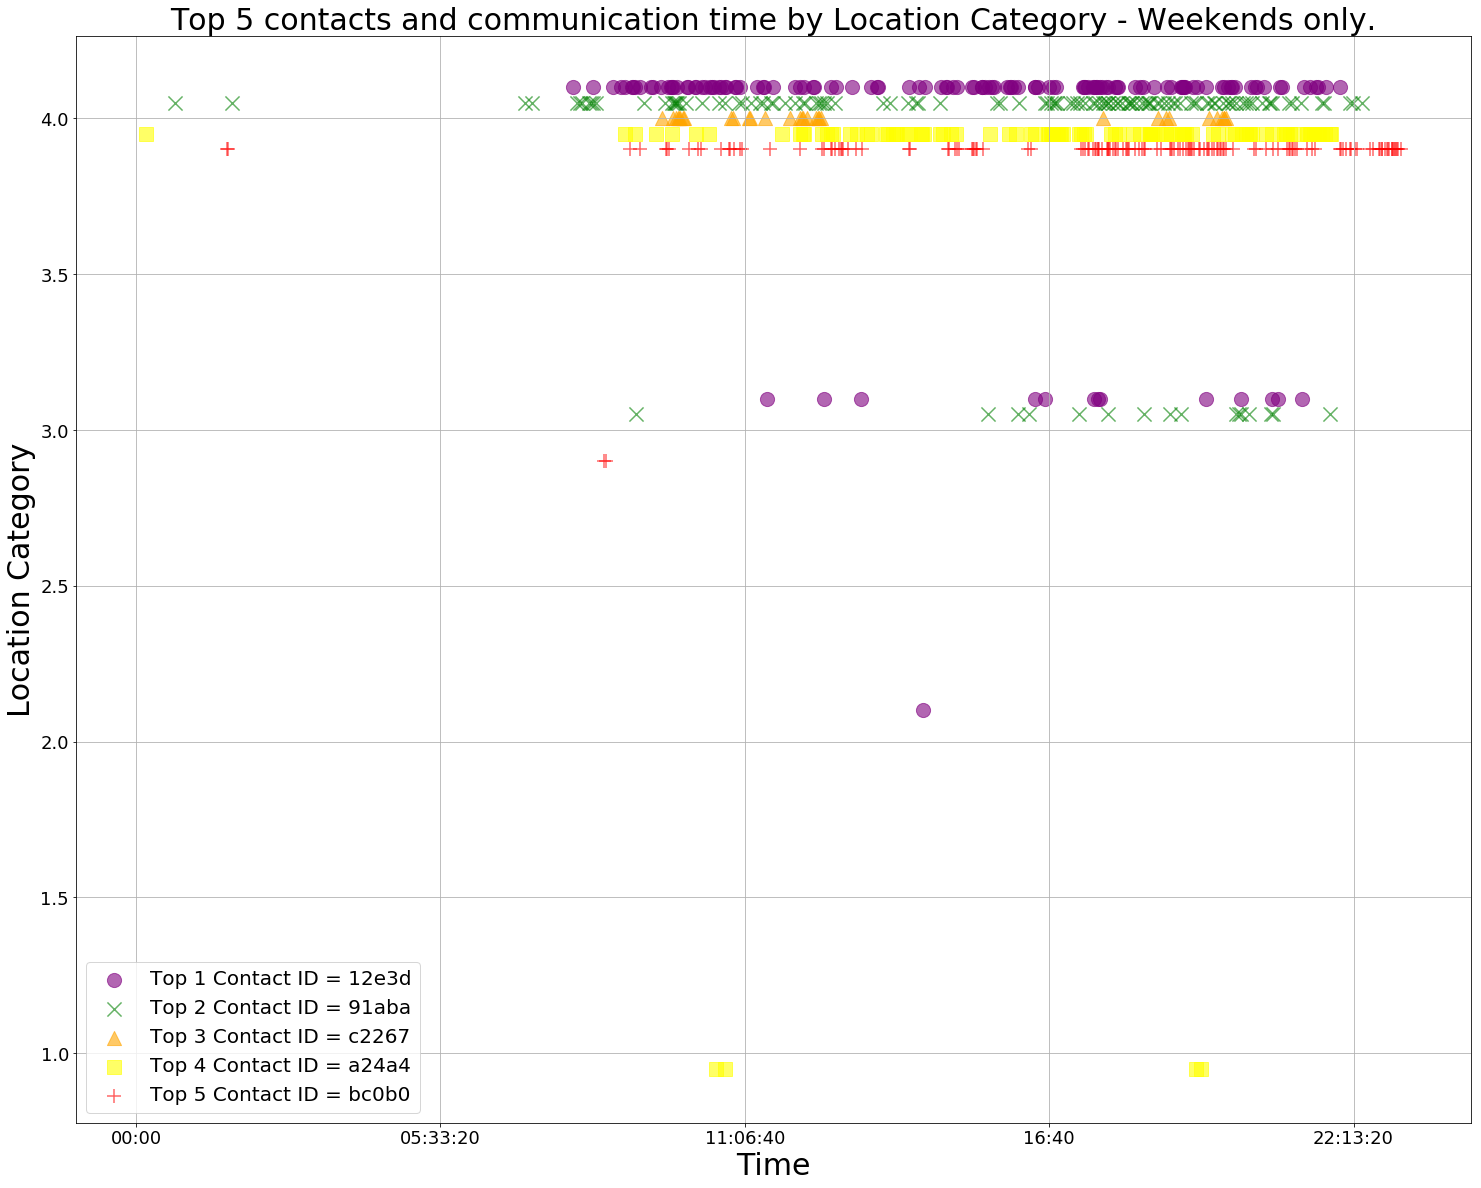

In [19]:
#Here's is the same approach done above, the difference is that there's a filter that will keep only weekend data.
#Weekend Data Analysis
top_ids = pd.DataFrame(df[df['communication_weekday'] > 4].groupby('Comm Identifier').count()['Latitude'].sort_values(ascending=False).head(5)).reset_index()
top_ids = list(top_ids['Comm Identifier'])

#Creating my plot
plt.figure(figsize=(25,20))

#Loop to plot each dataframe
for idx, comm_id in enumerate(top_ids):
    color = ['purple','green','orange','yellow','red']
    chart_adj = [.1,.05,0,-.05,-.1]
    marker = ['o', 'x', '^', 's', '+']
    label = 'Top ' + str(idx + 1) + ' Contact ID = ' + str(comm_id[:5])
    top_df = pd.DataFrame(df[df['Comm Identifier'] == comm_id].groupby(['communication_hour','geometry_category']).count()['communication_year'].reset_index())
    top_df.reset_index(inplace=True)
    top_df_chart = pd.DataFrame(top_df, columns = ['communication_hour','geometry_category'])
    top_df_chart['geometry_category'] = top_df_chart['geometry_category'] + chart_adj[idx]
    top_df_chart.set_index(['communication_hour'],inplace=True)
    plt.scatter(top_df_chart.index, top_df_chart['geometry_category'], s = 200, c = color[idx], label = label, marker = marker[idx], alpha = .6)
    title = 'Top ' + str(len(top_ids)) + ' contacts and communication time by Location Category - Weekends only.'

#More plotting here.
plt.title(title, fontsize = 30)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.xlabel('Time', fontsize = 30)
plt.ylabel('Location Category', fontsize = 30)
plt.legend(prop={'size': 20});

### Interestingly, the Top 1 contact from the plot before, goes to fifth during the weekends, I suspect that most of the communication between the user and 'bc0b0' is work related.

### Another point is that there's not much yellows in location three, which makes me think maybe 'a24a4' is the person the user goes to see in location 3. The same logic applies to the chart that includes all days of the week.

## Routine by Cell Tower Location Analysis:
#### The next analysis is focused on the user's routine based on the Cell Tower Location of each record overtime. My idea is to find out the top routines using different parameters. I'm trying to find patterns (like goes from Location A to Location B everyday). and maybe figure out something else later on. 
#### To achieve this, there will be two different loops running in parallel, one through the Cell Tower Location column (which is chronologically ordered) and then the first location will be added to a temporary list, for the next Tower Location, the script will check whether the last element of the list is the same, if that's the case, the loop will continue, ortherwise, the new location will be added. 
#### The temporary list will be complete once it reaches the max num that will be definied by the first loop, once that happens, the temporary list will be added to a master list and then resetted. The first looop is just a range, since it's complicated to know what's the optimal number of locations to define a routine, the max num will change and then at the add the top five results will be added to a Dataframe to be analyzed.

In [20]:
#Creating a list of the Tower Locations so I can loop through.
tower_locations = list(df['Cell Tower Location'])

#A dataframe placeholder to add the results of each iteration.
df_result = pd.DataFrame([[0,0,0]],columns = ['locations','count','max'])

#Create empty lists
master_list = []
temporary_list = []

#Initiating my first loop with the max num of elements (i.e. max number of locations in a routine)
for max_elements in range(3,8):
    for location in tower_locations: #looping through list of locations
        if len(temporary_list) == 0: #if the temporary list is empty, add the location
            temporary_list.append(location)
        elif len(temporary_list) == max_elements: #if the lenght of temporary list equals max number, append it to master_list and reset temporary_list
            master_list.append(temporary_list)
            temporary_list = []
        elif location != temporary_list[-1]: #if current location on the loop is not equals to last location added, then add this new location to temporary_list.
            temporary_list.append(location)
        else:
            continue
    result_to_df = [] #create an empty list to add the routines with total count
    for routine in master_list: #give me the count of routine in master_list and add routine and count to result_to_df list
        count_of_routine = master_list.count(routine)
        result_to_df.append((routine,count_of_routine))
    master_list = [] #reset my master_list for next loop
    temp_df = pd.DataFrame(result_to_df, columns = ['locations','count']) #transform result_to_df list into a dataframe
    temp_df['max'] = max_elements #create 'max' column to able to identify how many elements we were analyzing
    temp_df['locations'] = temp_df['locations'].map(str)
    temp_df.drop_duplicates(inplace=True) #drop duplicates of routines
    temp_df = pd.DataFrame(temp_df.sort_values('count', ascending = False).reset_index()[['locations','count','max']][:5]) #sort by count, reset index and pick top five.
    df_result = df_result.append(temp_df, ignore_index = True) #append top three to df_result dataframe

#Drop the first row of the dataframe, it's the placeholder we created.
df_result.drop(0,0, inplace = True)

In [21]:
#It's time to see the results!
df_result = df_result.sort_values(['locations'])
df_result

,locations,count,max
25,"['BALGOWLAH HAYES ST', 'HARBORD 22 WAINE ST', ...",4,7
21,"['BALGOWLAH HAYES ST', 'HARBORD 22 WAINE ST', ...",16,7
16,"['BALGOWLAH HAYES ST', 'HARBORD 22 WAINE ST', ...",23,6
11,"['BALGOWLAH HAYES ST', 'HARBORD 22 WAINE ST', ...",44,5
6,"['BALGOWLAH HAYES ST', 'HARBORD 22 WAINE ST', ...",54,4
1,"['BALGOWLAH HAYES ST', 'HARBORD 22 WAINE ST', ...",134,3
24,"['BRICKWORKS', 'SUNDERLAND ST', 'BRICKWORKS', ...",5,7
18,"['BRICKWORKS', 'SUNDERLAND ST', 'BRICKWORKS', ...",7,6
13,"['BRICKWORKS', 'SUNDERLAND ST', 'BRICKWORKS', ...",11,5
10,"['BRICKWORKS', 'SUNDERLAND ST', 'BRICKWORKS', ...",12,4


### The results are really insteresting, I was able to find the following routines:
   - Balgowlah Hayes St > Harbord 22 Waine St. I believe this is home and work, since it has the biggest count.
   - Brickworks > Sunderland St. 
   - Chippendale > Haymarket.